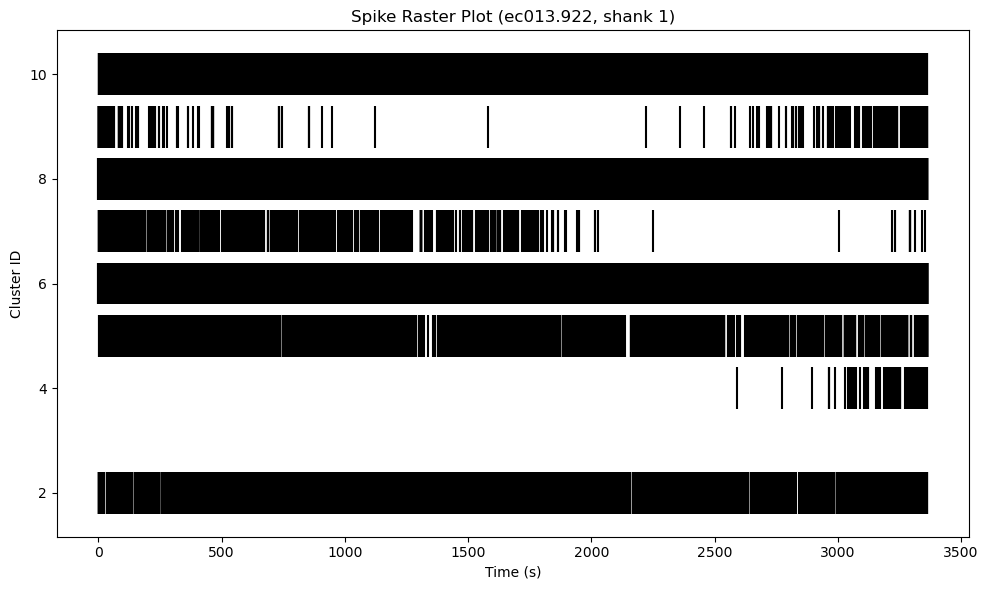

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

# === Parameters ===
base = "ec013.922"
shank = 1
sampling_rate = None  

# === Load XML for metadata ===
def get_sampling_rate(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    return int(root.find('acquisitionSystem').find('samplingRate').text)

if os.path.exists(f"{base}.xml"):
    sampling_rate = get_sampling_rate(f"{base}.xml")
else:
    sampling_rate = 20000  # fallback default (20kHz)

# === Load Data ===
res = np.loadtxt(f"{base}.res.{shank}", dtype=int)
clu = np.loadtxt(f"{base}.clu.{shank}", dtype=int)
import pandas as pd
fet = pd.read_csv(f"{base}.fet.{shank}", sep='\t', header=None)

n_clusters = clu[0]
clu = clu[1:]

assert len(clu) == len(res), "Mismatch between clu and res lengths!"

# Convert spike times from samples to seconds
res_sec = res / sampling_rate

# === Plot Raster ===
fig, ax = plt.subplots(figsize=(10, 6))

for cluster_id in range(2, n_clusters):  # usually 0 = noise, 1 = MUA
    spike_times = res_sec[clu == cluster_id]
    ax.vlines(spike_times, cluster_id - 0.4, cluster_id + 0.4, color='black')

ax.set_xlabel("Time (s)")
ax.set_ylabel("Cluster ID")
ax.set_title(f"Spike Raster Plot ({base}, shank {shank})")
plt.tight_layout()
plt.show()


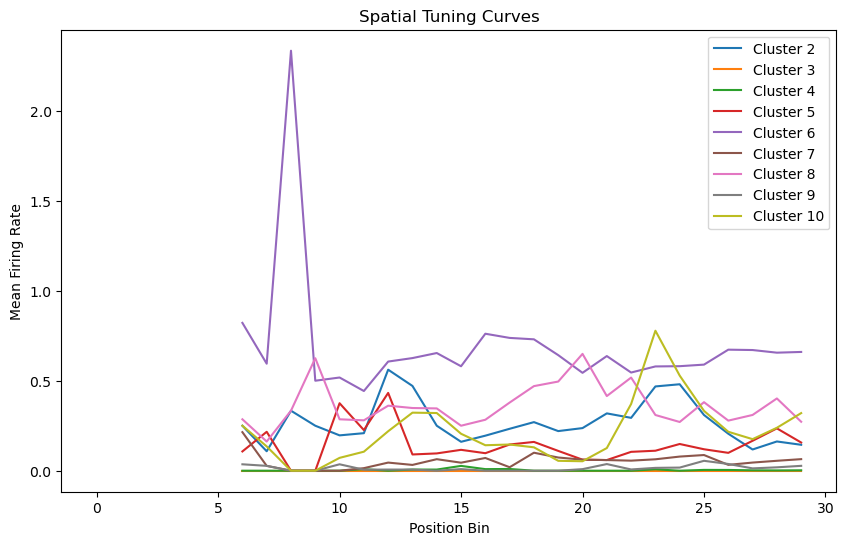

In [12]:
plt.figure(figsize=(10, 6))
for c in range(2, n_clusters + 1):
    fr_vs_pos, _, _ = binned_statistic(pos_binned, spike_counts[c], statistic='mean', bins=30)
    plt.plot(fr_vs_pos, label=f'Cluster {c}')
plt.xlabel("Position Bin")
plt.ylabel("Mean Firing Rate")
plt.title("Spatial Tuning Curves")
plt.legend()
plt.show()


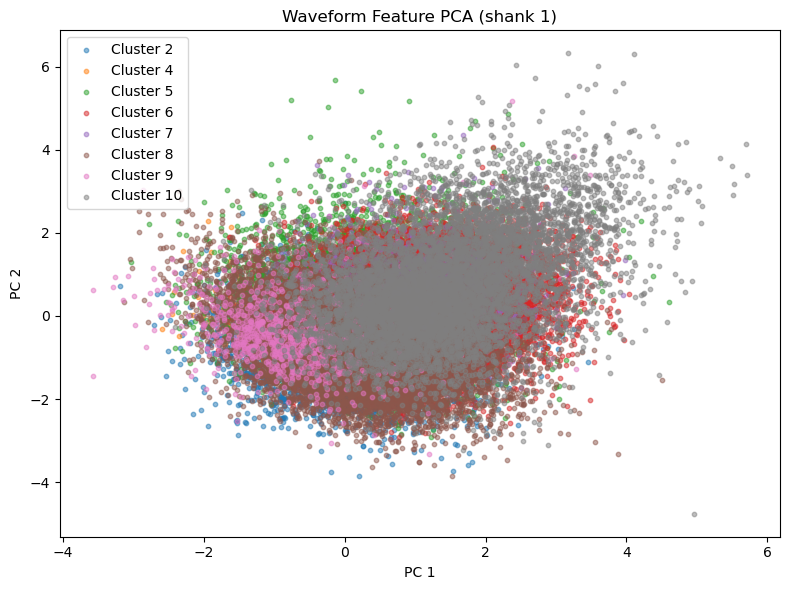

In [40]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Remove first column if it's the spike index (common in MClust-style files)
if fet.shape[1] > 1 and np.all(fet.iloc[:, 0] == np.arange(1, fet.shape[0] + 1)):
    fet = fet.iloc[:, 1:]

assert len(clu) == len(res) == fet.shape[0], "Mismatch in data lengths!"

# === PCA for Dimensionality Reduction ===

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
fet_scaled = scaler.fit_transform(fet)

pca = PCA(n_components=2)
fet_pca = pca.fit_transform(fet_scaled)

# === Visualize Waveform Feature Space ===
plt.figure(figsize=(8, 6))
for cluster_id in np.unique(clu):
    if cluster_id < 2:  # skip noise and MUA
        continue
    idx = clu == cluster_id
    plt.scatter(fet_pca[idx, 0], fet_pca[idx, 1], label=f'Cluster {cluster_id}', alpha=0.5, s=10)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title(f'Waveform Feature PCA (shank {shank})')
plt.legend()
plt.tight_layout()
plt.show()

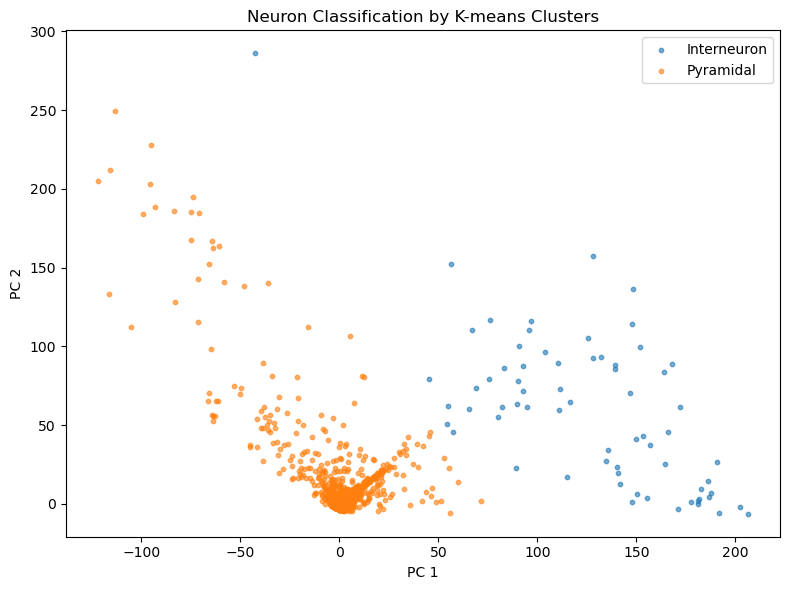

In [41]:
# Map cluster IDs to neuron types based on domain knowledge or cluster inspection
cluster_to_type = {0: 'Pyramidal', 1: 'Interneuron'}
neuron_types = [cluster_to_type[label] for label in labels]

# Plot with labels
plt.figure(figsize=(8,6))
for neuron_type in set(neuron_types):
    idx = [i for i, nt in enumerate(neuron_types) if nt == neuron_type]
    plt.scatter(fet_pca[idx, 0], fet_pca[idx, 1], label=neuron_type, alpha=0.6, s=10)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Neuron Classification by K-means Clusters')
plt.legend()
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


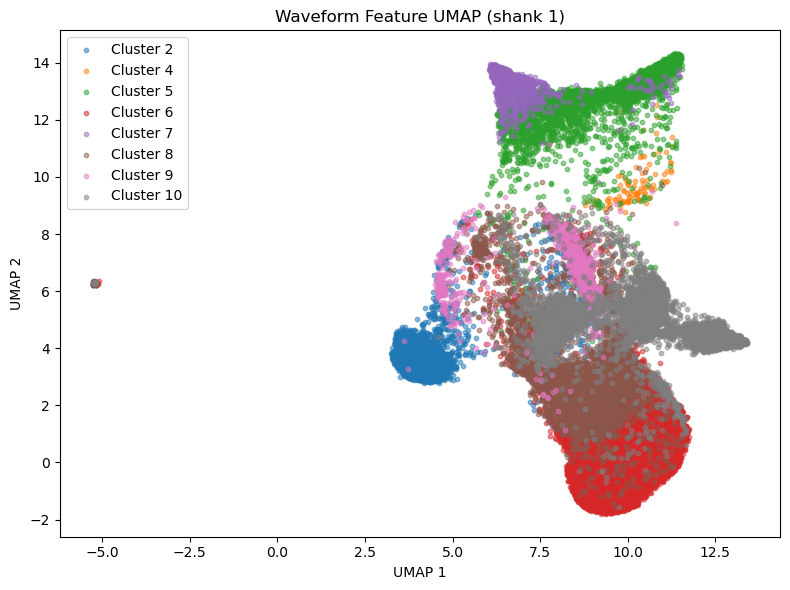

In [33]:
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np

# Run UMAP (on already scaled features)
reducer = UMAP(n_components=2, random_state=42)
fet_umap = reducer.fit_transform(fet_scaled)

# Plot UMAP output
plt.figure(figsize=(8, 6))
for cluster_id in np.unique(clu):
    if cluster_id < 2:
        continue
    idx = clu == cluster_id
    plt.scatter(fet_umap[idx, 0], fet_umap[idx, 1], label=f'Cluster {cluster_id}', alpha=0.5, s=10)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f'Waveform Feature UMAP (shank {shank})')
plt.legend()
plt.tight_layout()
plt.show()



/var/folders/5d/6gp5wczs0n9d5k2v4mvlpk2m0000gn/T/ipykernel_92330/1255074863.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fet = pd.read_csv(f"{base}.fet.{shank}", delim_whitespace=True, header=None, skiprows=1)


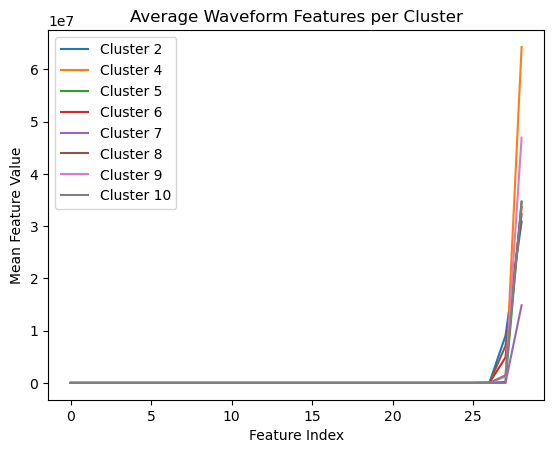

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load features (make sure to adjust for your actual file and format)
fet = pd.read_csv(f"{base}.fet.{shank}", delim_whitespace=True, header=None, skiprows=1)

# Remove index column if present (check if first column is spike index)
if fet.shape[1] > 1 and np.all(fet.iloc[:, 0] == np.arange(1, fet.shape[0] + 1)):
    fet = fet.iloc[:, 1:]

# Load cluster assignments and spike times
clu = np.loadtxt(f"{base}.clu.{shank}", dtype=int)
res = np.loadtxt(f"{base}.res.{shank}", dtype=int)

n_clusters = clu[0]
clu = clu[1:]

# Plot average of first waveform feature (e.g. spike width) per cluster
for cluster_id in np.unique(clu):
    if cluster_id < 2:  # skip noise and MUA
        continue
    idx = clu == cluster_id
    mean_feat = np.mean(fet[idx], axis=0)
    plt.plot(mean_feat, label=f'Cluster {cluster_id}')

plt.xlabel('Feature Index')
plt.ylabel('Mean Feature Value')
plt.title('Average Waveform Features per Cluster')
plt.legend()
plt.show()


